In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Tomato_Dataset

/content/drive/MyDrive/Tomato_Dataset


In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers,models
import matplotlib.pyplot as plt
import keras
from keras.layers import Resizing
from keras.layers import Rescaling
from keras.layers import RandomFlip
from keras.layers import RandomRotation

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=15

In [ ]:
#load data using tf dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tomato_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 18258 files belonging to 10 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Leaf Mold',
 'Mosaic Virus',
 'Septoria leaf Spot',
 'Spider Mites Two Spotted ',
 'Target Spot',
 'Yellow Leaf Curl Virus']

In [ ]:
#here our len is 501 because our batch size is 32
len(dataset)

1142

In [ ]:
1001*16

16016

(16, 256, 256, 3)
[0 3 3 8 5 4 2 8 4 8 7 8 5 4 0 1]


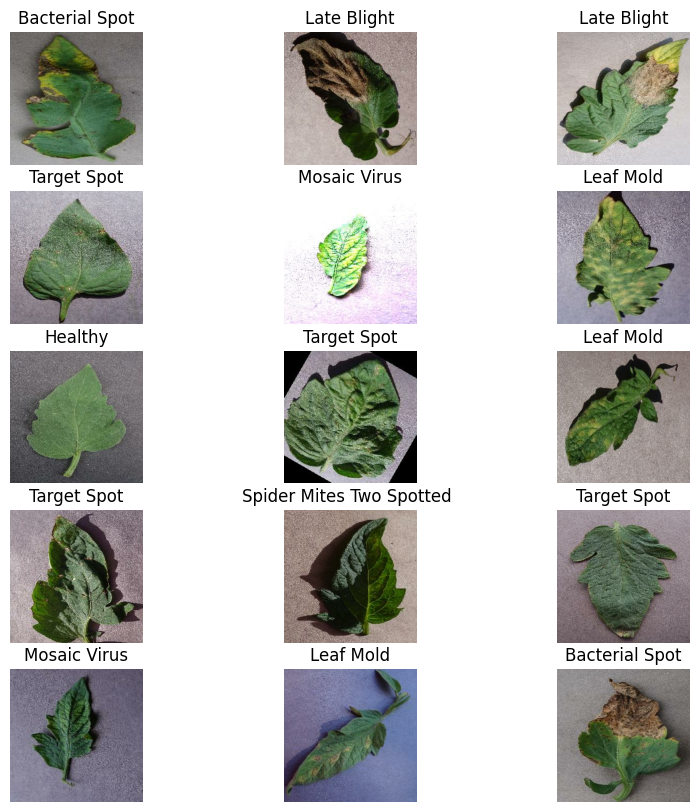

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(15):
        ax=plt.subplot(5,3,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_size=0.8
len(dataset)*train_size

913.6

In [ ]:
train_ds=dataset.take(800)
len(train_ds)

800

In [ ]:
test_ds=dataset.skip(800)
len(test_ds)

342

In [ ]:
val_size=0.1
len(dataset)*val_size

114.2

In [ ]:
val_ds=test_ds.take(100)
len(val_ds)

100

In [ ]:
test_ds=test_ds.skip(100)
len(test_ds)

242

In [ ]:
def get_dataset_partition_tf(ds, train_split=0.8,val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=15)

    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
len(train_ds)

913

In [ ]:
len(test_ds)

115

In [ ]:
len(val_ds)

114

In [ ]:
#caching & prefetch for improvement of performance for both GPU and CPU
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

In [ ]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes=10

model=models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds,
    )

Epoch 1/15
913/913 [==============================] - 373s 300ms/step - loss: 1.5464 - accuracy: 0.4209 - val_loss: 0.9906 - val_accuracy: 0.6486
Epoch 2/15
913/913 [==============================] - 245s 268ms/step - loss: 0.8853 - accuracy: 0.6814 - val_loss: 0.6381 - val_accuracy: 0.7796
Epoch 3/15
913/913 [==============================] - 244s 267ms/step - loss: 0.5923 - accuracy: 0.7905 - val_loss: 0.4413 - val_accuracy: 0.8383
Epoch 4/15
913/913 [==============================] - 244s 267ms/step - loss: 0.4415 - accuracy: 0.8451 - val_loss: 0.3335 - val_accuracy: 0.8810
Epoch 5/15
913/913 [==============================] - 242s 265ms/step - loss: 0.3465 - accuracy: 0.8811 - val_loss: 0.3208 - val_accuracy: 0.8980
Epoch 6/15
913/913 [==============================] - 243s 266ms/step - loss: 0.2818 - accuracy: 0.9008 - val_loss: 0.2972 - val_accuracy: 0.9013
Epoch 7/15
913/913 [==============================] - 242s 265ms/step - loss: 0.2365 - accuracy: 0.9195 - val_loss: 0.3394 -

In [ ]:
model.save('/content/drive/My Drive/Tomato_Dataset'+'/tomato.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = keras.models.load_model(r"/content/drive/My Drive/Tomato_Dataset/tomato.h5")

In [ ]:
scores=model.evaluate(test_ds)

115/115 [==============================] - 35s 53ms/step - loss: 0.1470 - accuracy: 0.9685


In [ ]:
scores

[0.14699548482894897, 0.968478262424469]

In [ ]:
history

In [ ]:
 history.params

{'verbose': 1, 'epochs': 15, 'steps': 913}

In [ ]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
 history.history['accuracy']

[0.42085787653923035,
 0.6814444065093994,
 0.7905303835868835,
 0.8451418280601501,
 0.8811155557632446,
 0.9008496403694153,
 0.919487476348877,
 0.9305194020271301,
 0.9423735737800598,
 0.9453200101852417,
 0.9529944062232971,
 0.957585334777832,
 0.9613539576530457,
 0.9653282165527344,
 0.9644374251365662]

In [ ]:
 history.history['loss']

[1.54644775390625,
 0.885340690612793,
 0.5922719836235046,
 0.44151049852371216,
 0.3465096950531006,
 0.28182071447372437,
 0.2365170121192932,
 0.2012062966823578,
 0.1696818619966507,
 0.15633678436279297,
 0.1370297521352768,
 0.11842263489961624,
 0.11450058966875076,
 0.10701045393943787,
 0.10323139280080795]

In [ ]:
history.history['val_loss']

[0.9905720949172974,
 0.638056218624115,
 0.4412860572338104,
 0.3335246741771698,
 0.3207639455795288,
 0.29722604155540466,
 0.33939099311828613,
 0.20527195930480957,
 0.23779532313346863,
 0.20431657135486603,
 0.1332368552684784,
 0.19931918382644653,
 0.09699438512325287,
 0.10970788449048996,
 0.11181988567113876]

In [ ]:
history.history['val_accuracy']

[0.6485745906829834,
 0.7796052694320679,
 0.8382675647735596,
 0.8810306787490845,
 0.8980262875556946,
 0.9013158082962036,
 0.8799341917037964,
 0.9303728342056274,
 0.9177631735801697,
 0.9292762875556946,
 0.9544956088066101,
 0.9331140518188477,
 0.9720394611358643,
 0.968201756477356,
 0.9676535129547119]

In [ ]:
#now i will plot this all parameters in nice matplotlib graph
acc=history.history['accuracy']
loss=history.history['loss']

val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

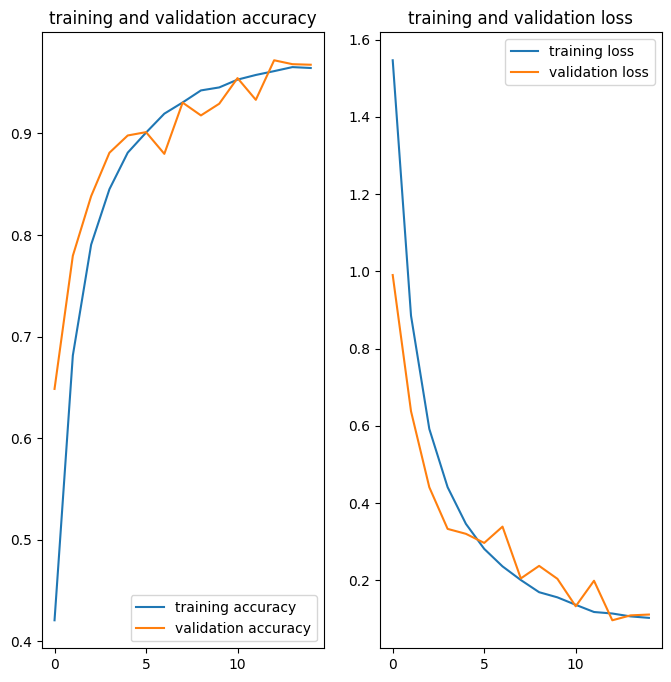

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc,label='training accuracy')
plt.plot(range(EPOCHS), val_accuracy,label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss,label='training loss')
plt.plot(range(EPOCHS), val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')

first image to predict
first image's actual label: Bacterial Spot
1/1 [==============================] - 0s 195ms/step
predicted label: Bacterial Spot


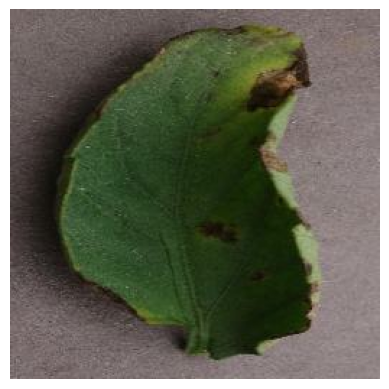

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_lable=labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("first image's actual label:", class_names[first_lable])

    batch_prediction=model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
#creating a function which is take input as image and return a predicted class name and confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


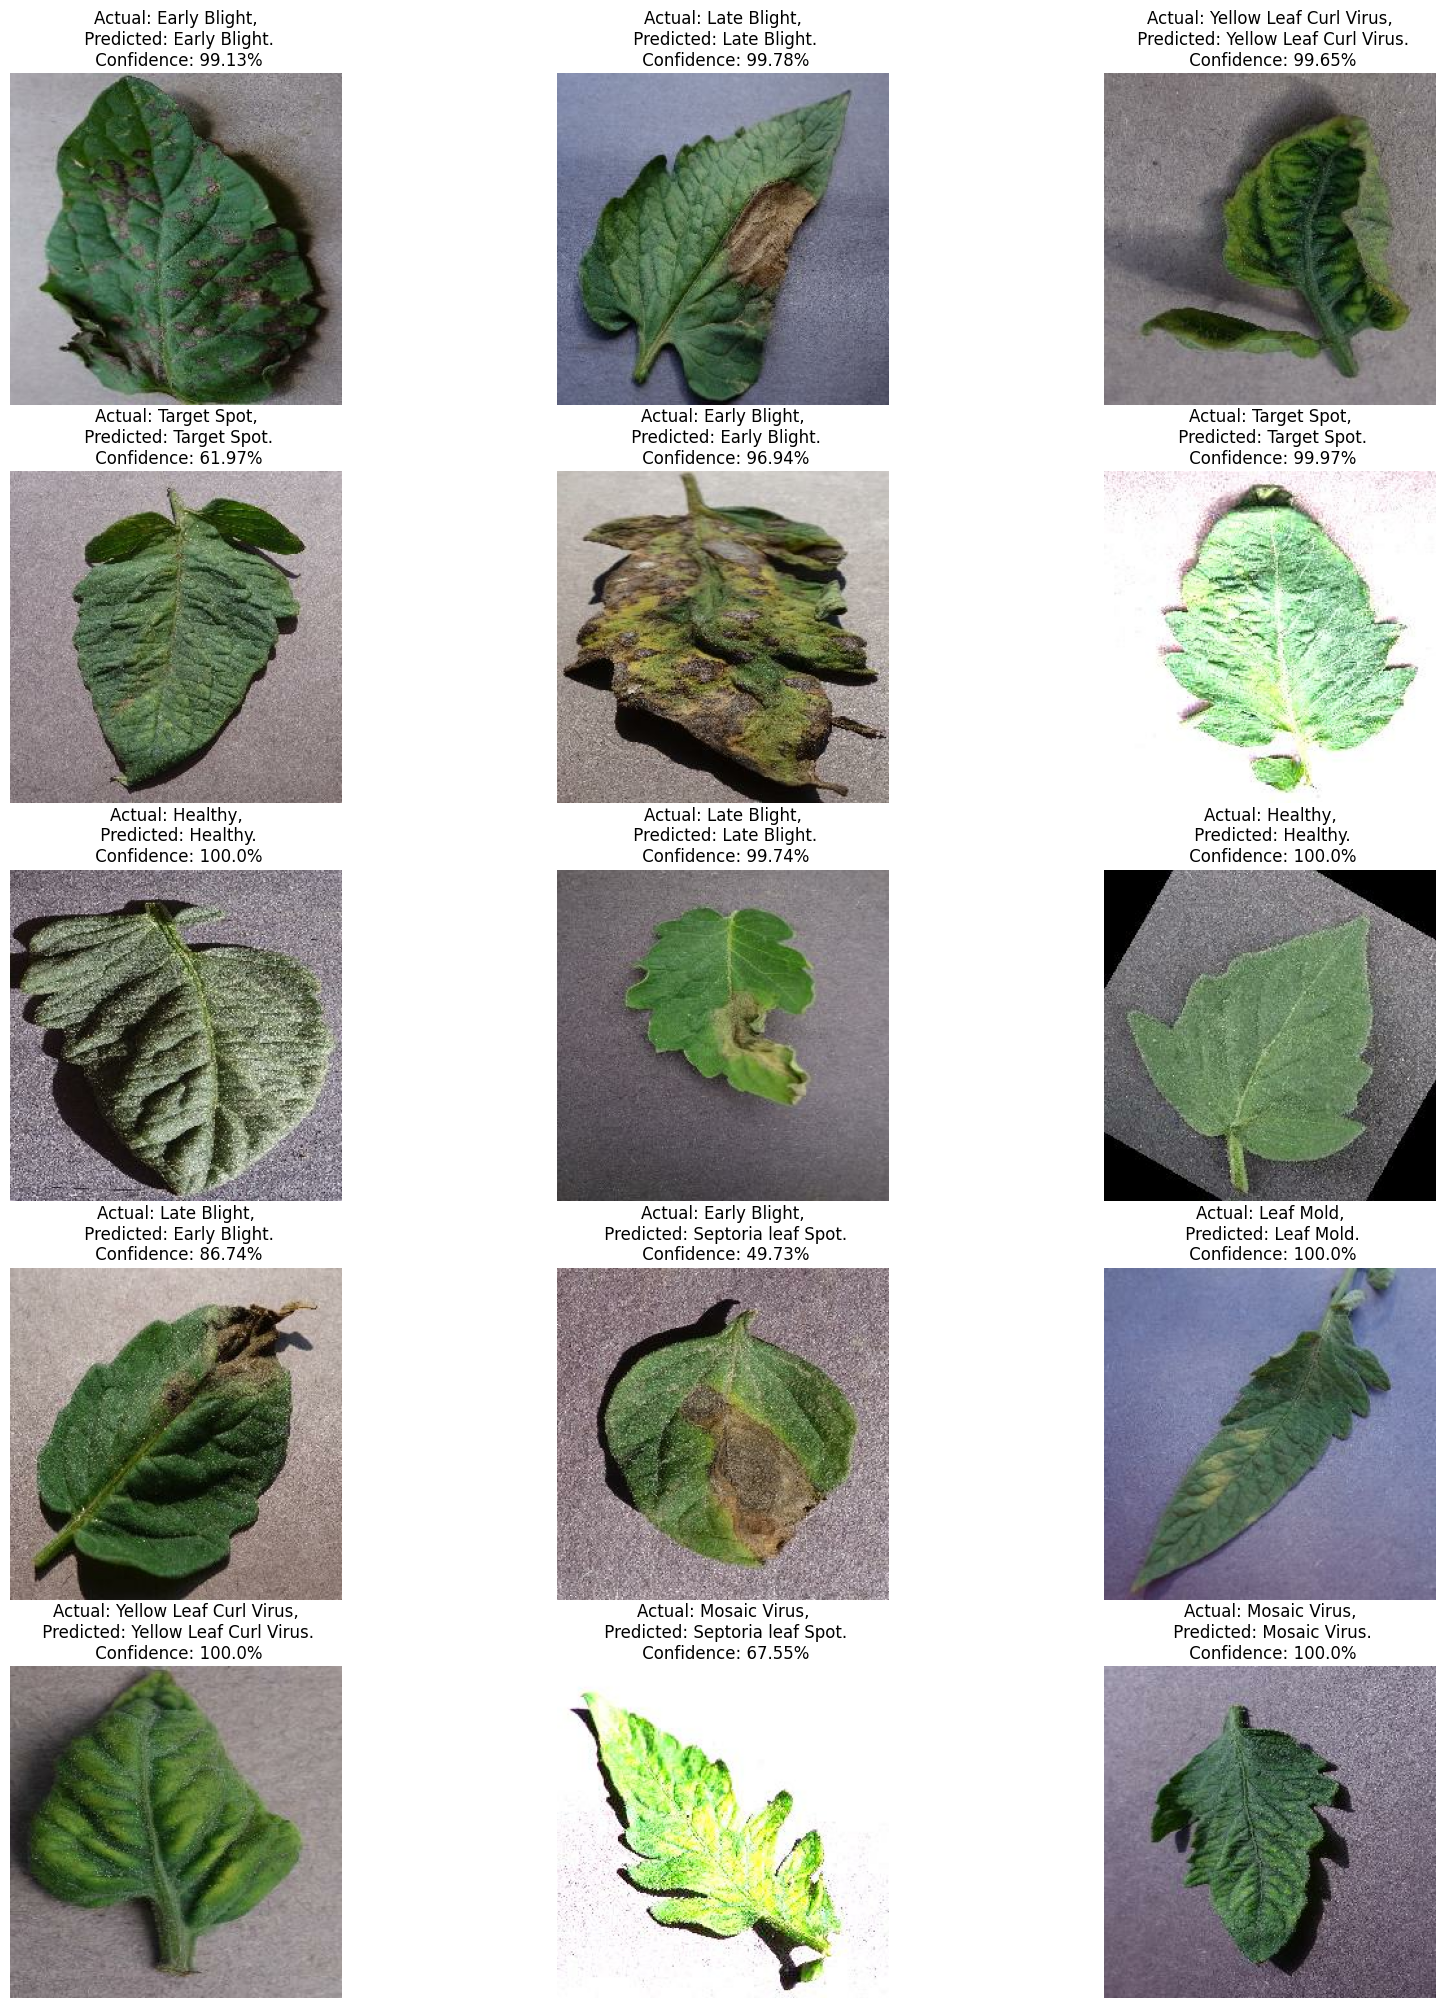

In [ ]:
plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")